In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from mlp_feats import MLP
from mlp_feats import train_model
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [20]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')
%matplotlib

Using matplotlib backend: agg


In [21]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [22]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
print(R_all_c)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
[[['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra' ... 'Left substantia nigra'
   'Left substantia nigra' 'Left substantia nigra']
  ['Right Substantia nigra' 'Right Substantia nigra'
   'Right Substantia nigra' ... 'Right Substantia nigra'
   'Right Substantia nigra' 'Right Substantia nigra']
  ['Left subthalamic nucleus' 'Left subthalamic nucleus'
   'Left subthalamic nucleus' ... 'Left subthalamic nucleus'
   'Left subthalamic nucleus' 'Left subthalamic nucleus']
  ['Right subthalamic nucleus' 'Right subthalamic nucleus'
   'Right subthalamic nucleus' ... 'Right subthalamic nucleus'
   'Right subthalamic nucleus' 'Righ

Pre-crop size (131, 130, 92)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_01.nii.gz of shape (152, 152, 105)
Pre-crop size (130, 119, 88)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_02.nii.gz of shape (152, 152, 105)
Pre-crop size (130, 125, 97)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_03.nii.gz of shape (152, 152, 105)
Pre-crop size (115, 118, 88)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_04.nii.gz of shape (152, 152, 105)
Pre-crop size (151, 127, 97)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_05.nii.gz of shape (152, 152, 105)
Pre-crop size (123, 119, 102)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_06.nii.gz of shape (152, 152, 105)
Pre-crop size (120, 109, 81)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_07.nii.gz of shape (152, 152, 105)
Pre-crop size (134, 135, 85)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_08.nii.gz of shape (152, 152, 105)
Pre-cro

/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (127, 128, 102)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_26.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (131, 125, 104)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_27.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (134, 127, 89)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_36.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (121, 101, 93)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_37.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (133, 110, 103)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_39.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (126, 125, 93)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_40.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (125, 108, 95)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_41.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (119, 115, 100)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_42.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (121, 123, 93)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_44.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (130, 131, 98)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_45.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Pre-crop size (125, 119, 94)
Loading /home/ali/RadDBS-QSM/data/nii/qsm/QSM_e10_imaginary_46.nii.gz of shape (152, 152, 105)


/home/ali/RadDBS-QSM/src/jupyter/util.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


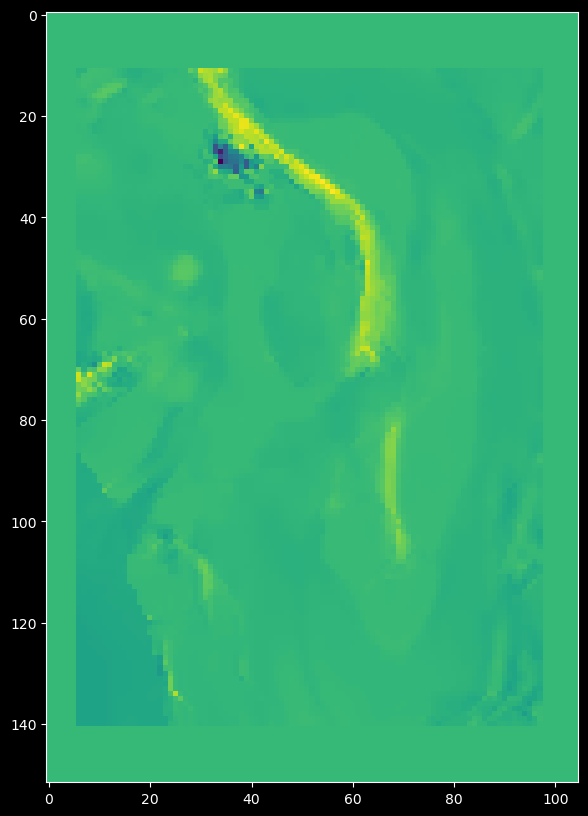

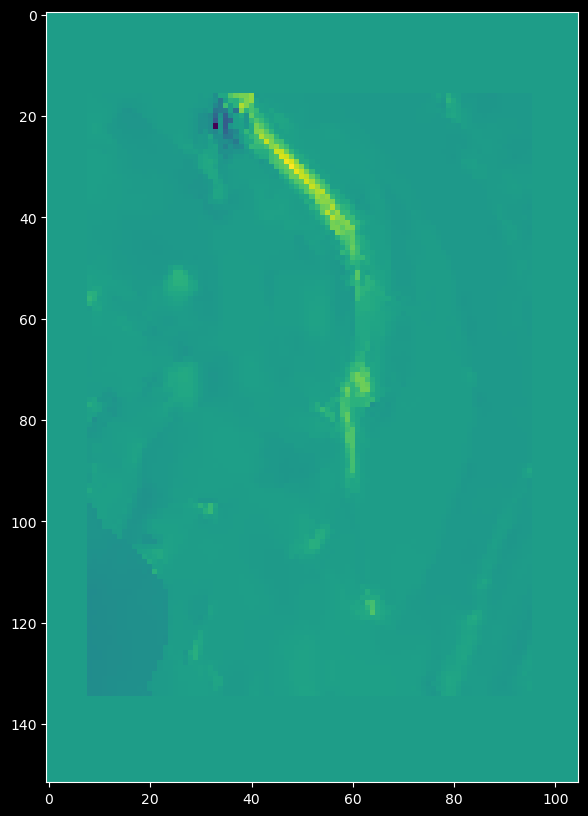

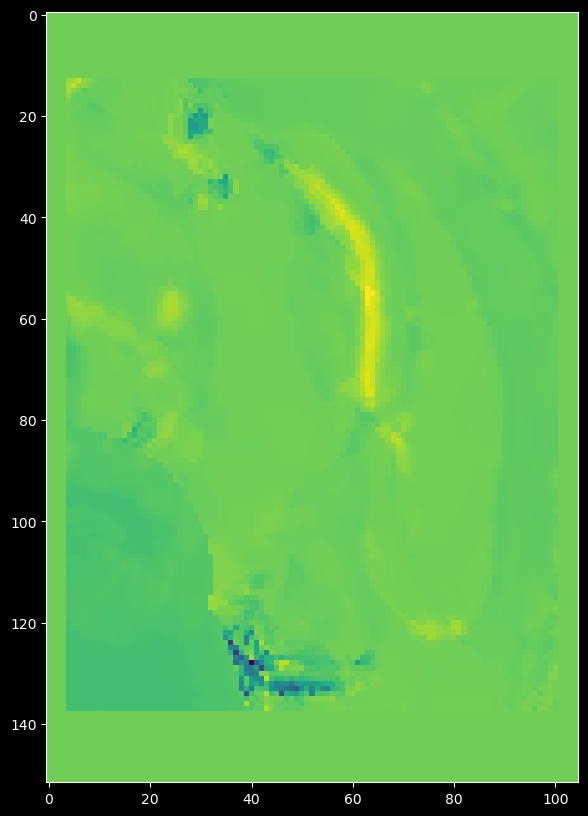

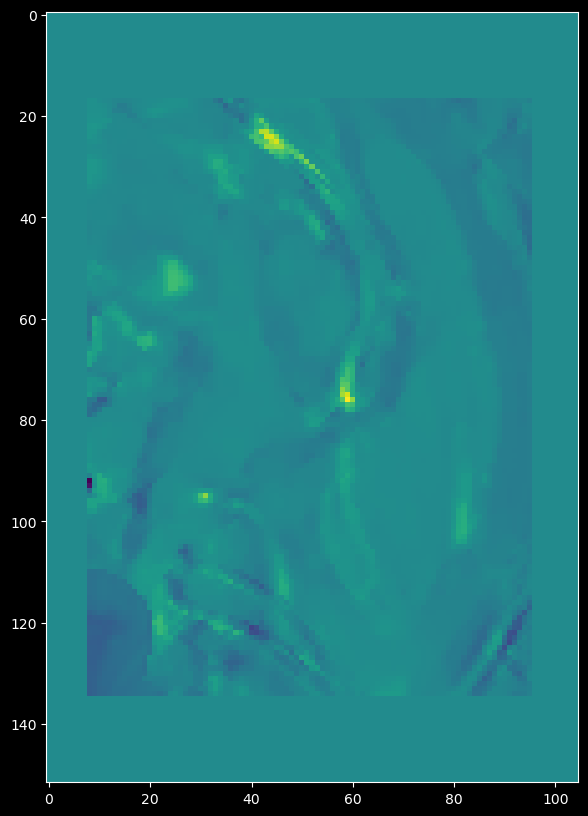

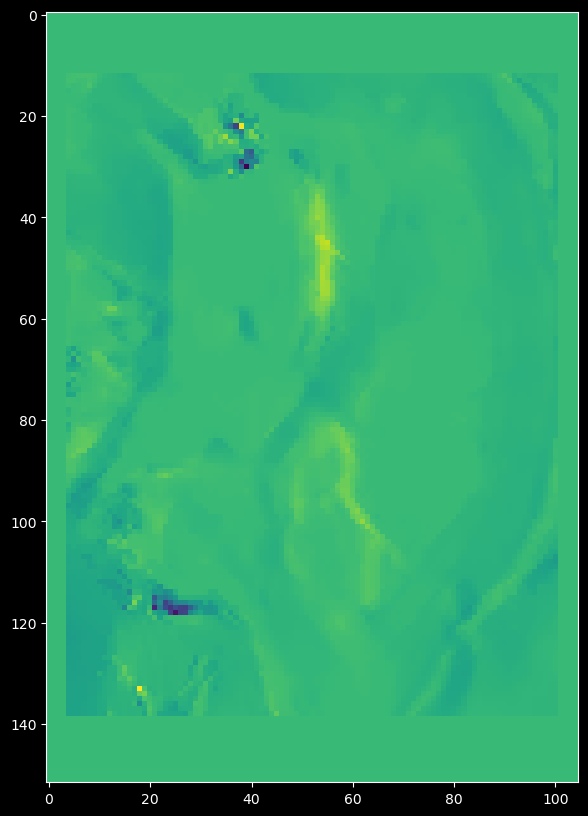

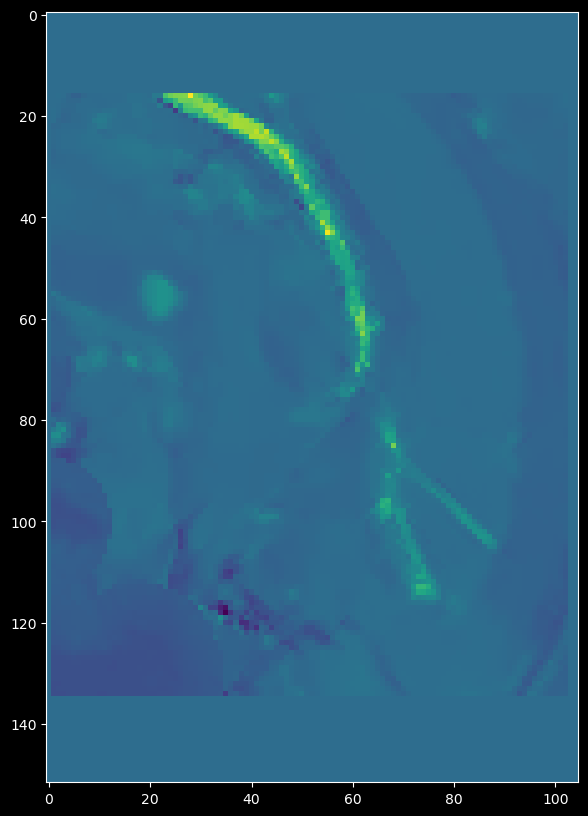

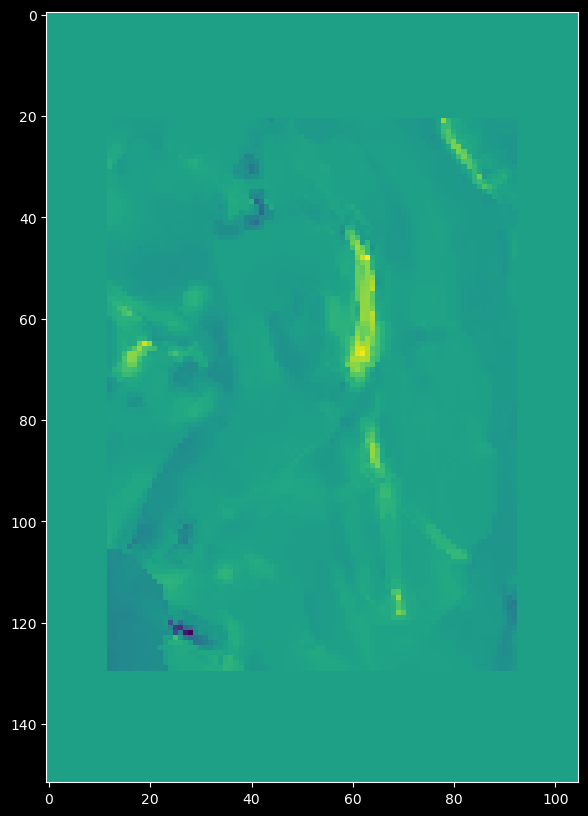

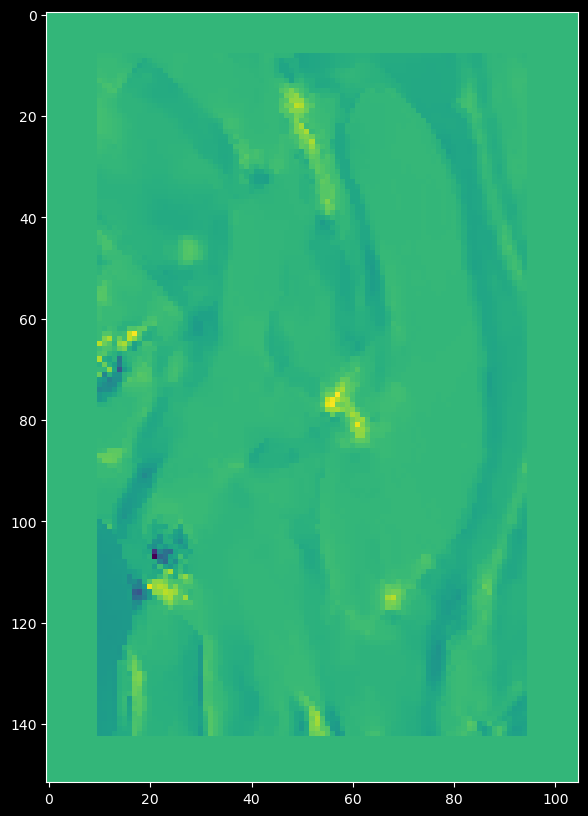

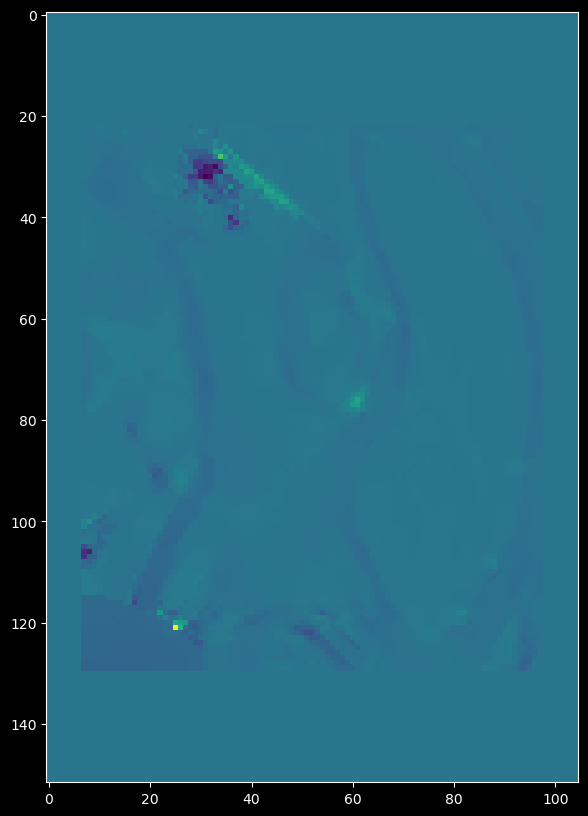

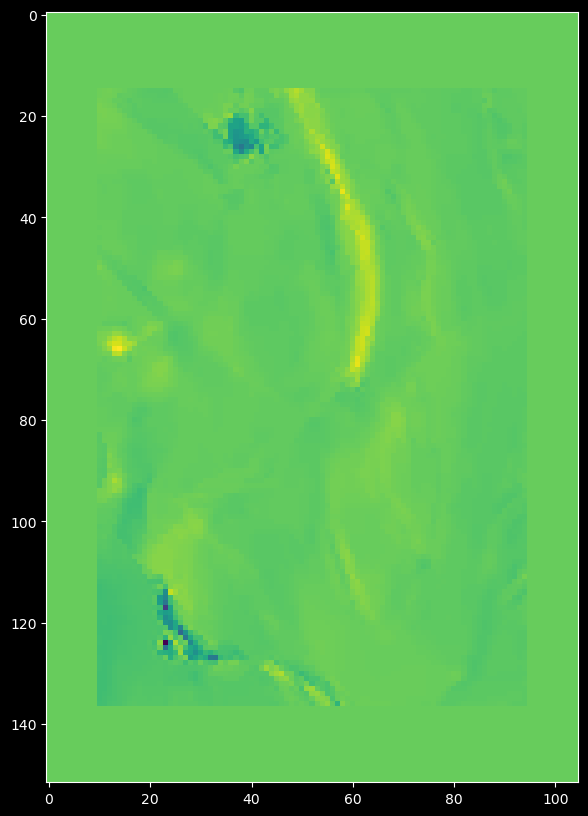

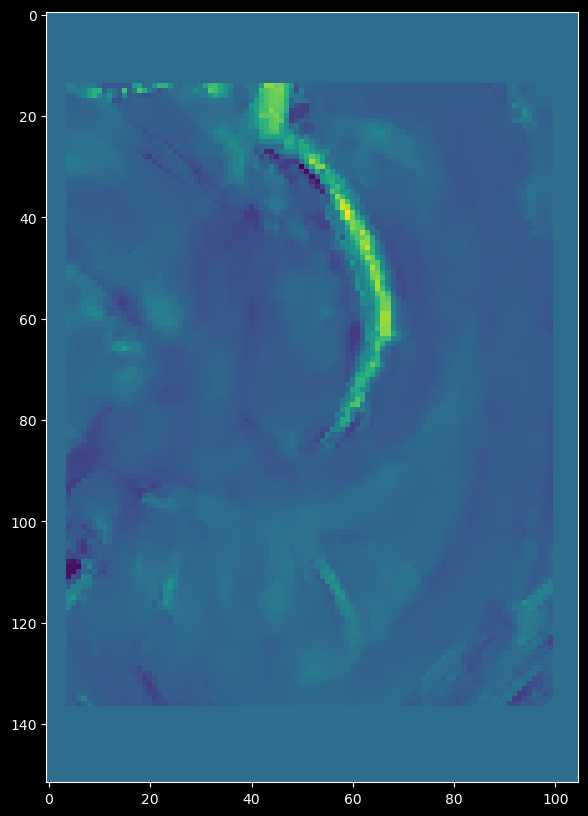

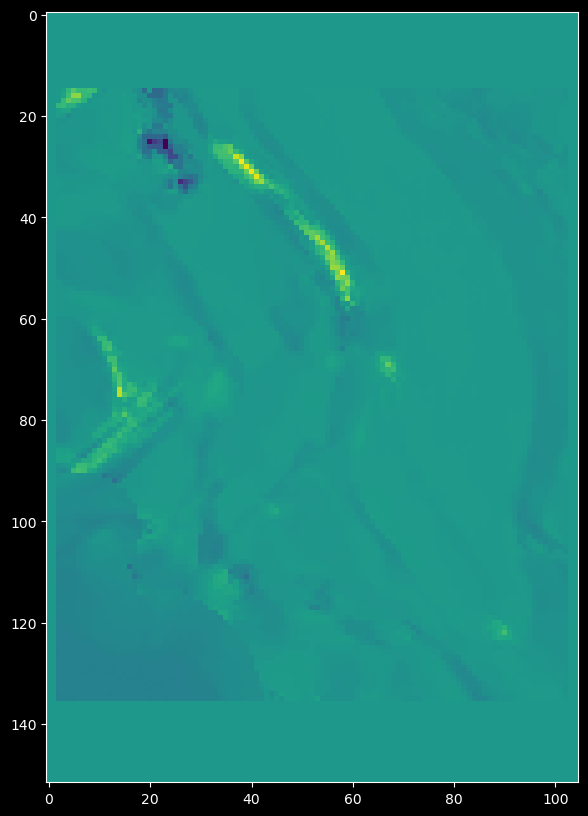

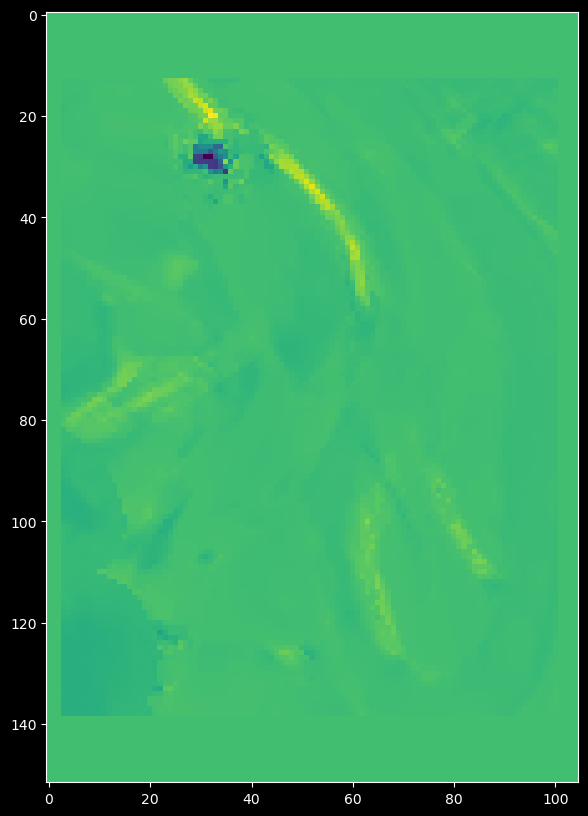

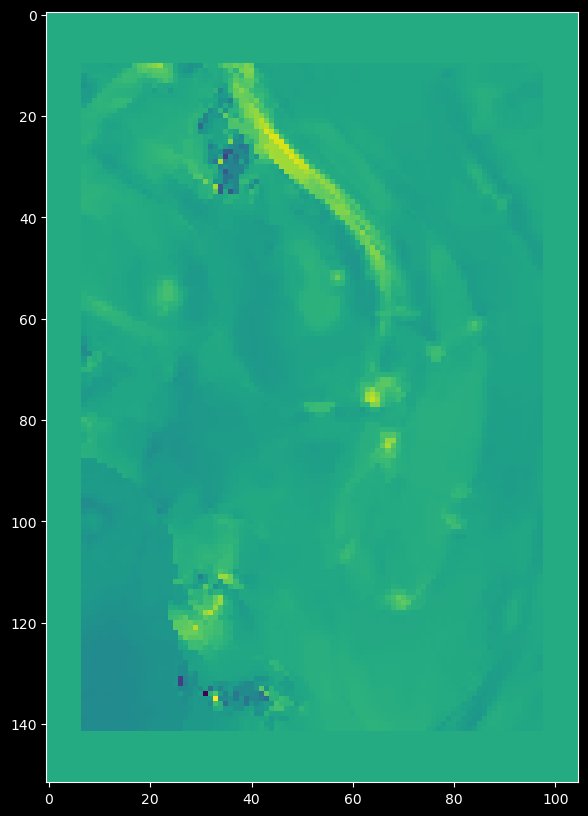

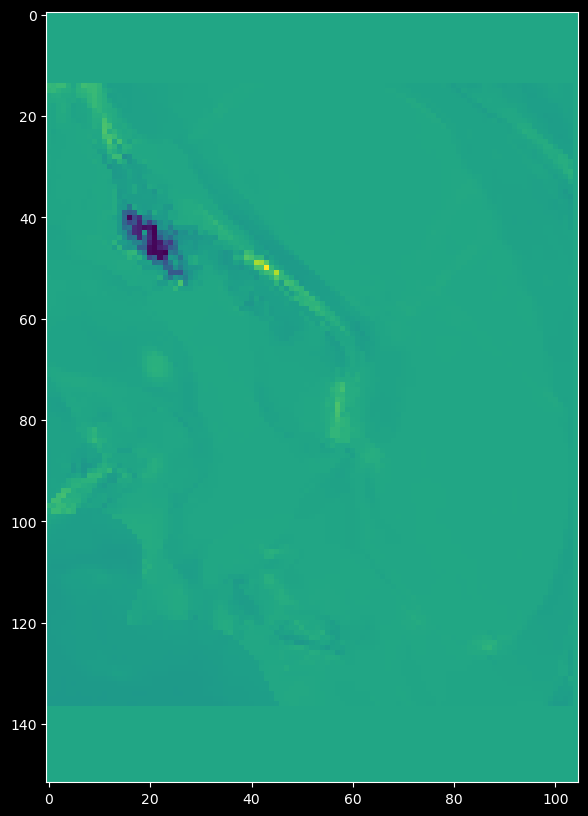

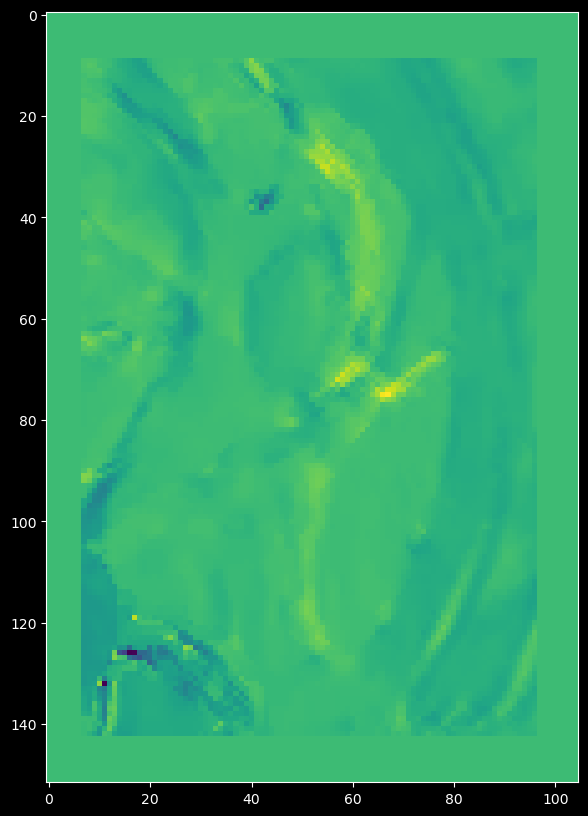

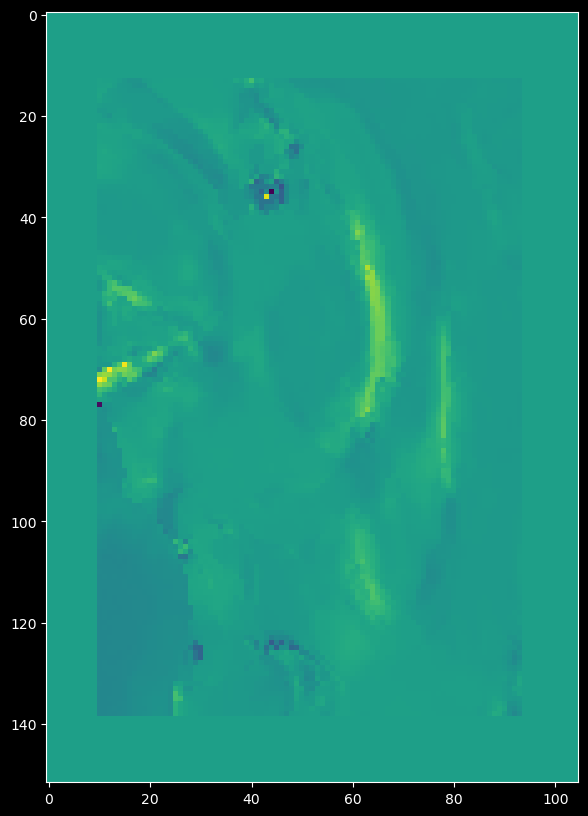

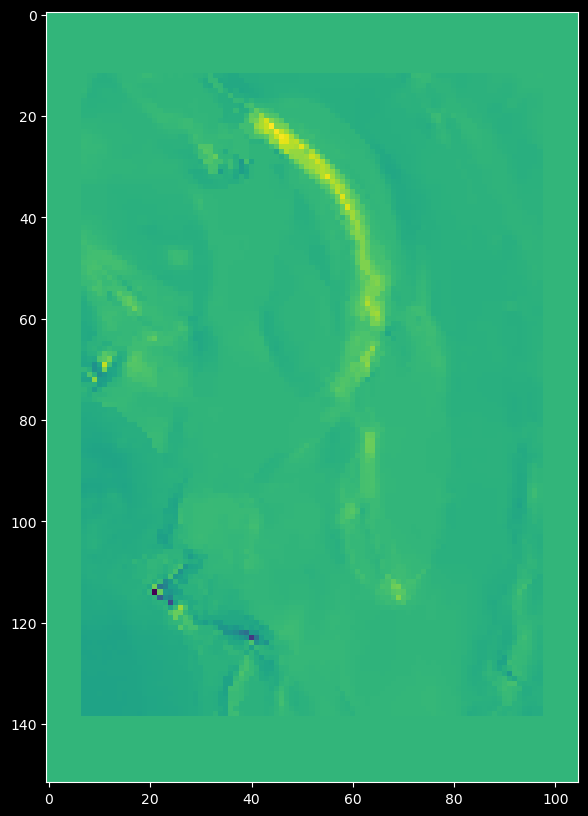

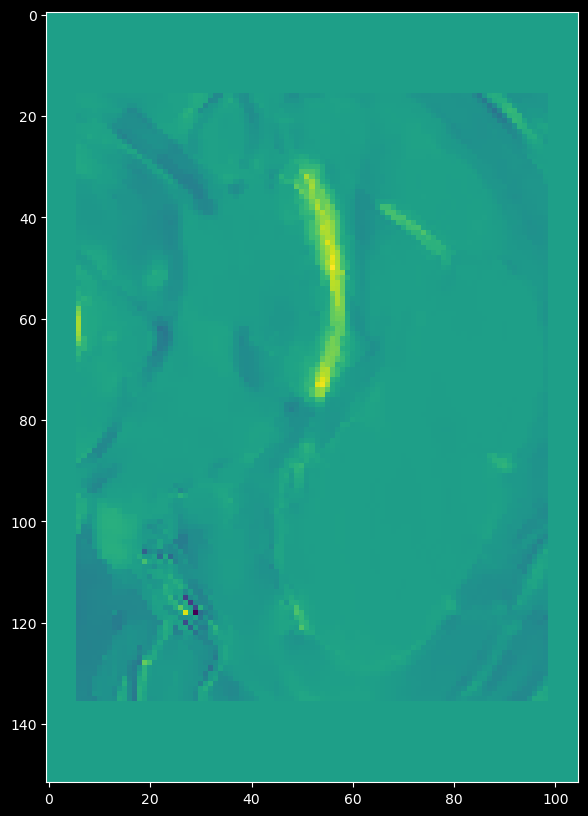

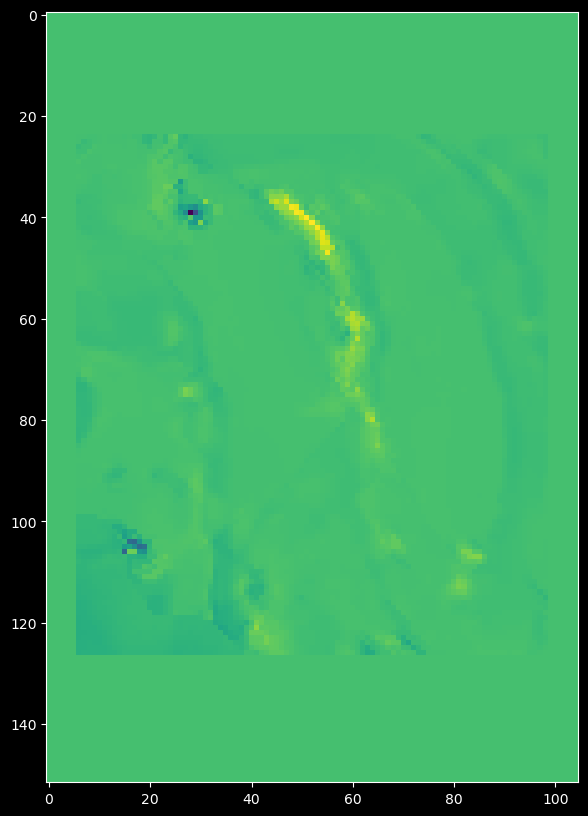

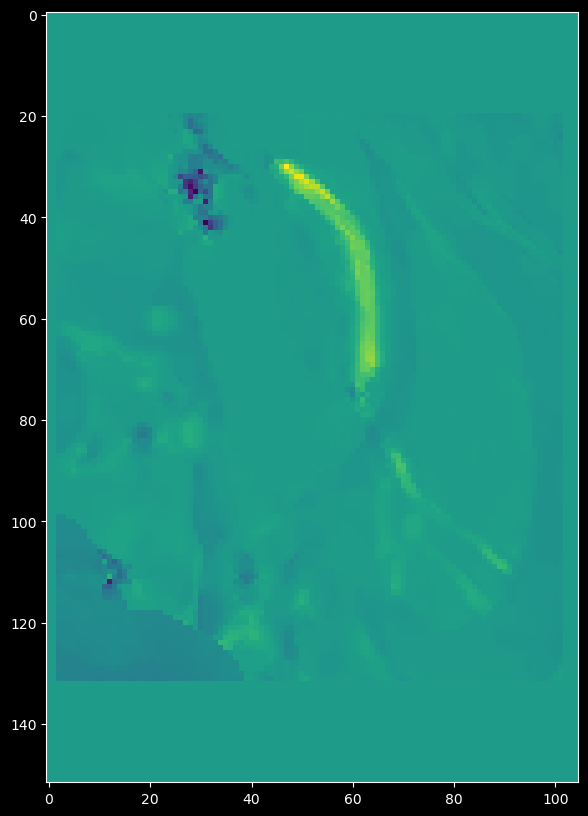

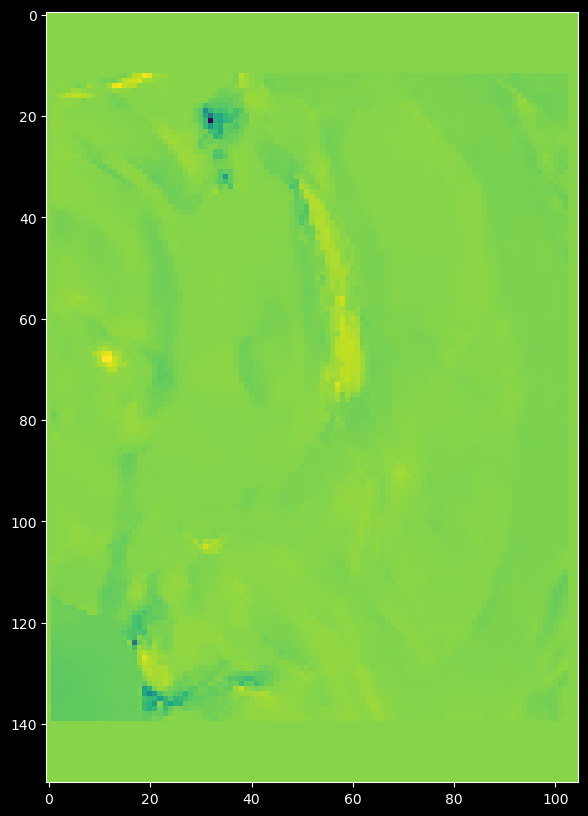

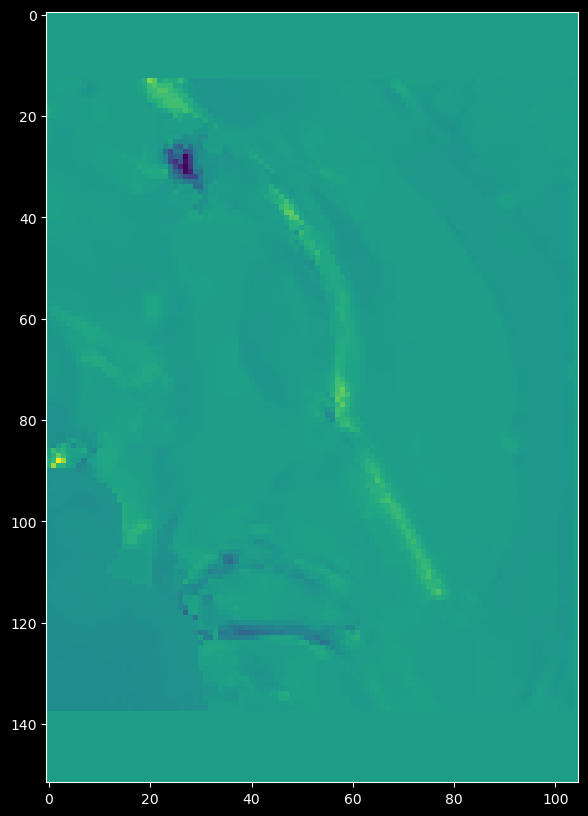

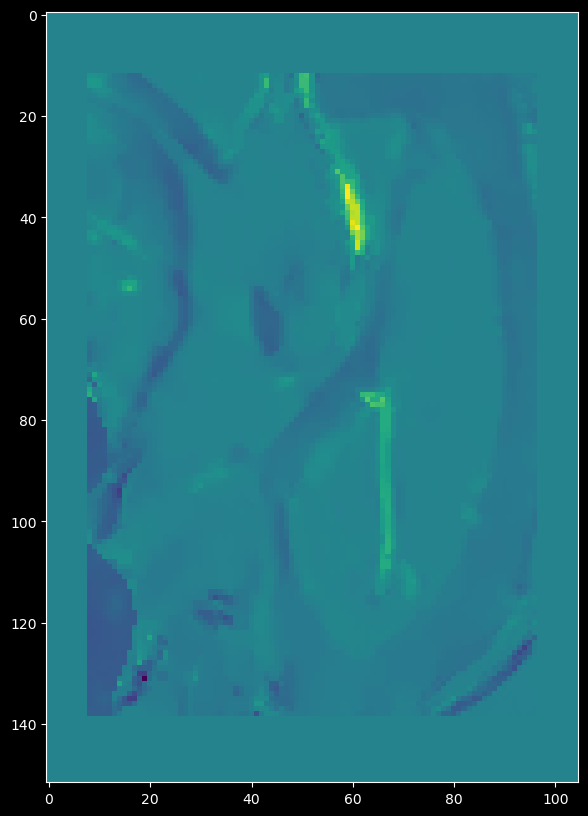

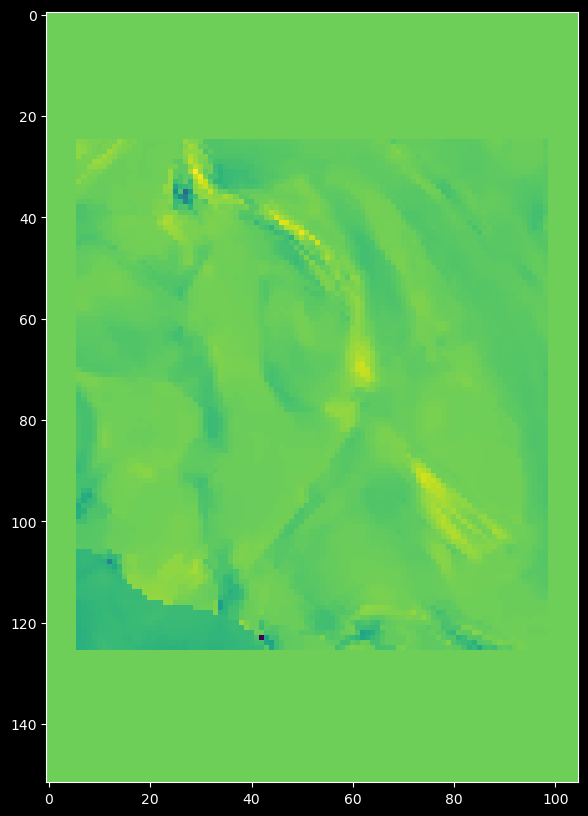

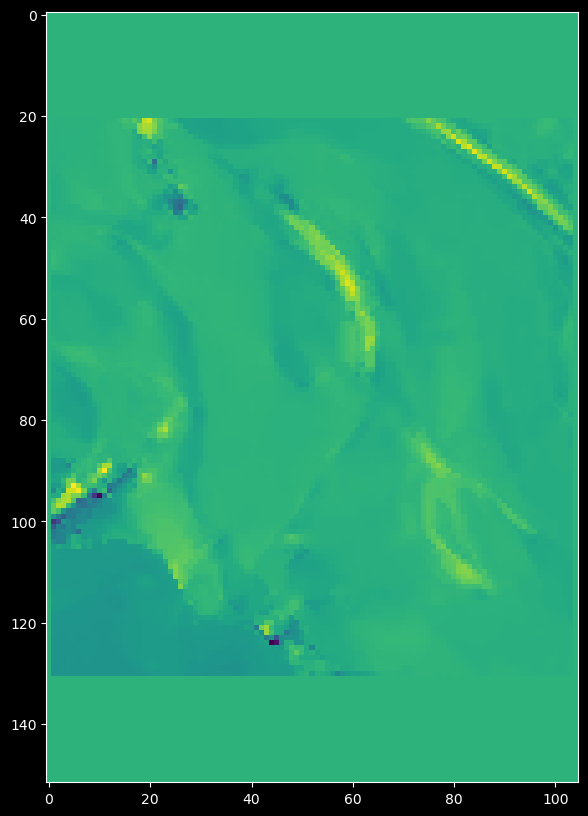

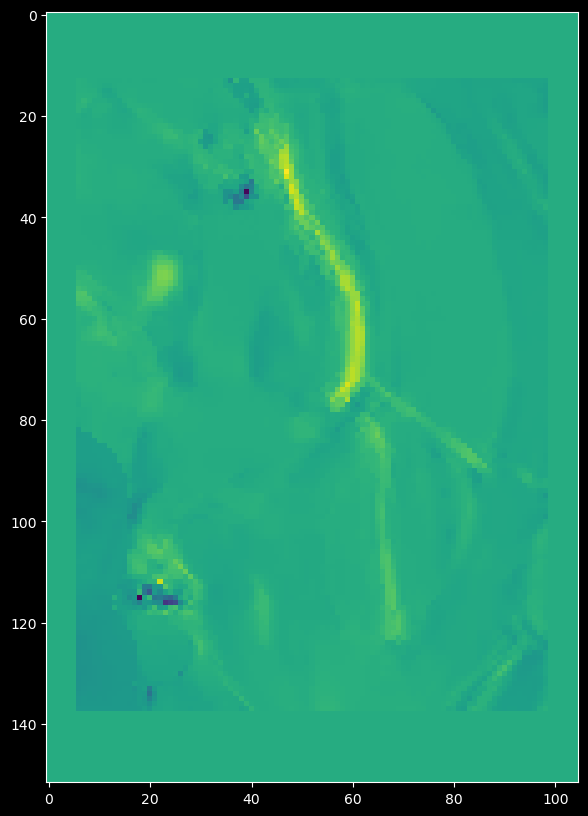

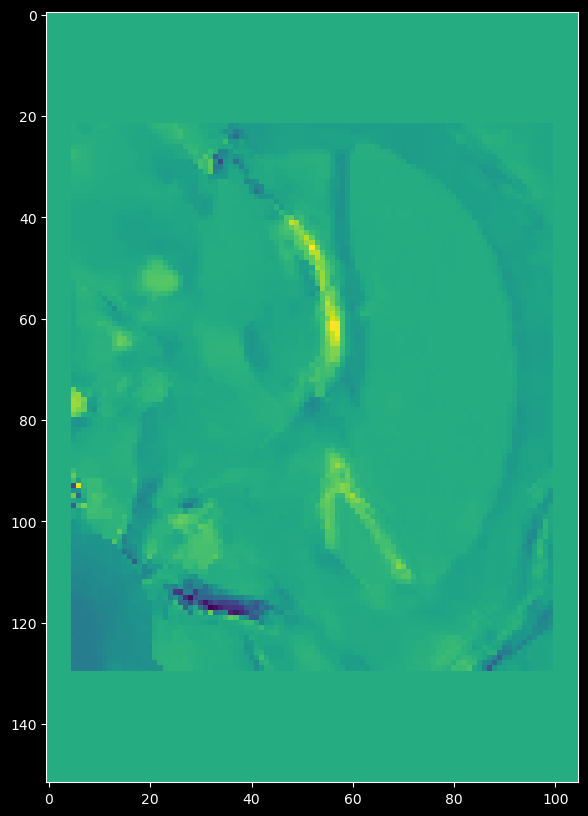

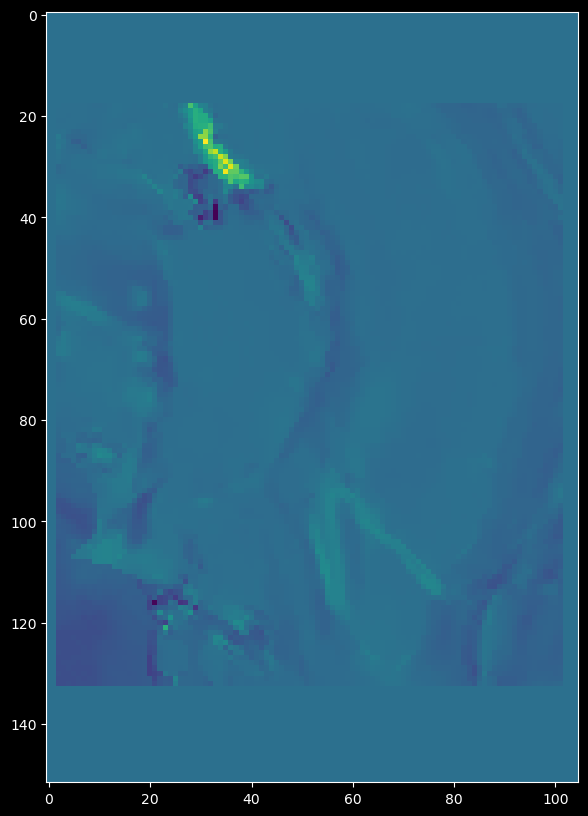

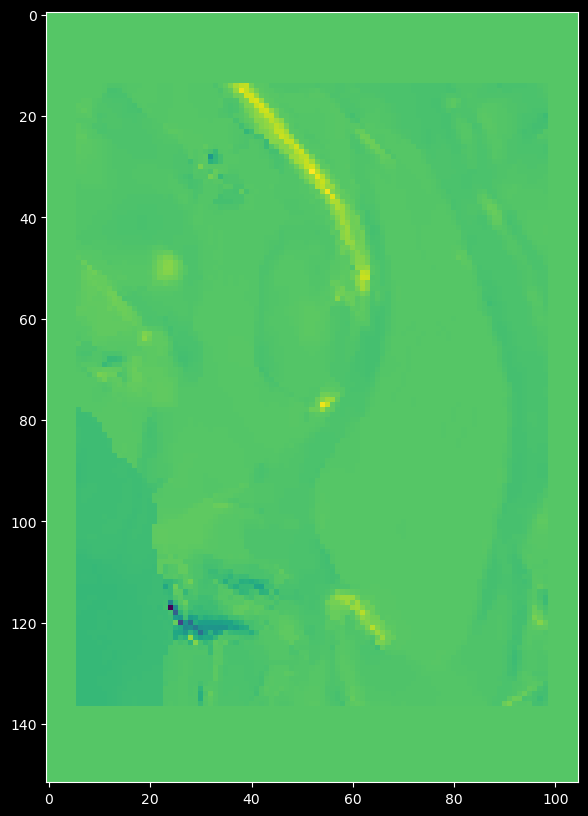

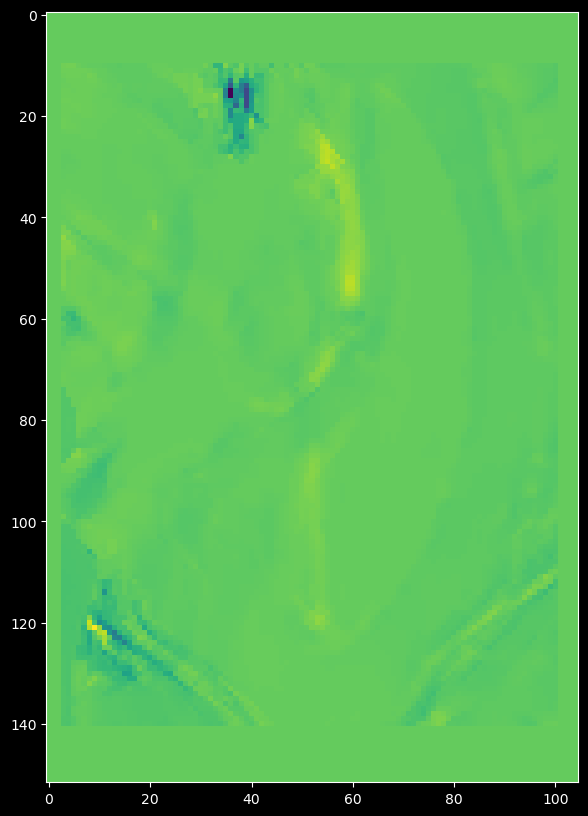

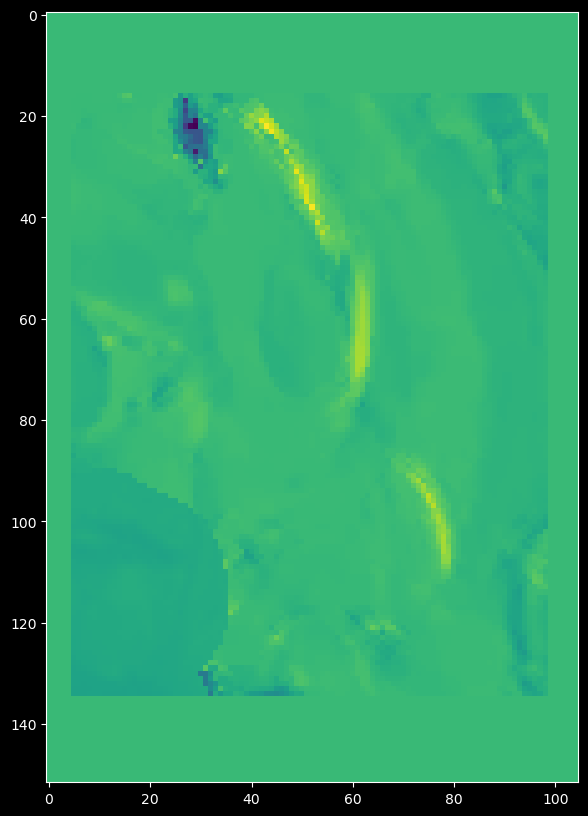

In [23]:
qsms = util.full_path('/home/ali/RadDBS-QSM/data/nii/qsm')
segs = util.full_path('/home/ali/RadDBS-QSM/data/nii/seg')
chi = []
for j in np.arange(len(qsms)):
    data = nib.load(qsms[j])
    if int(qsms[j][-9:-7]) == int(segs[j][-9:-7]):
        #try:
            mask = nib.load(segs[j]).get_fdata()
            img = util.mask_crop(data.get_fdata(),mask)
            print('Pre-crop size',str(img.shape))
            img = util.pad_to(img,152,152,105)
            util.pyvis(img,10,10)
            nib.save(nib.Nifti1Image(img,data.affine,data.header), '../../data/cropped/'+qsms[j][-9:-7])
            chi.append(img)
            print('Loading',qsms[j],'of shape',str(img.shape))
        # except:
        #     print('Skipping',qsms[j])
        #     subsc = np.delete(subsc,j)
        #     per_change = np.delete(per_change,j)
        #     X_all_c = np.delete(X_all_c,j,axis=0)
        #     pre_updrs_off = np.delete(pre_updrs_off,j)

In [ ]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []

In [ ]:
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    chi_train = np.asarray(chi)[train_index,:,:,:]
    chi_test = np.asarray(chi)[test_index,:,:,:]
    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,False)
    # X_test_ss0 = X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2])
    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=1800)
      #sel = skf.SequentialFeatureSelector(slm.Lasso(), n_features_to_select= 100, cv=cvn, n_jobs=-1)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      Ks.append(sel.transform(K.reshape(1, -1)))
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]

      encoder = MLP()
      yt = train_model(X0_ss,y_train,encoder,X_test_ss)
      scaler_lvs = skp.StandardScaler()
      print('Error of ',np.sum((X_test_ss-Xpt.cpu().detach().numpy())**2),'with prediction ',str(yt[0]),
            'for case with',str(np.round(per_change[j],2)))
      lvs = lvs.cpu().detach().numpy()
      lvst = lvst.cpu().detach().numpy()
      lvsp = scaler_lvs.fit_transform(lvs)
      lvstp = scaler_lvs.transform(lvst)
      X0_ss = np.append(X0_ss,lvs,axis=1)
      X_test_ss = np.append(X_test_ss,lvst,axis=1)
      sel = skf.SelectKBest(skf.r_regression,k=1800)
      X0_ss = sel.fit_transform(X0_ss,y_train)
      X_test_ss = sel.transform(X_test_ss)
      for k in np.arange(lvstp.shape[1]):
         lr = stats.linregress(lvs[:,k],y_train)
         if lr.rvalue > 0.4:
            print(lr.rvalue)

    # LASSO
    lasso = slm.LassoCV(max_iter=1e4,cv=cvn,n_jobs=-1)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
    w.append(est_ls.coef_)
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'for case with',str(np.round(per_change[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,4)),
          'and neighbor ',str(y_train[y_n]))


Error of  411.5837810830835 with prediction  tensor([0.1972], device='cuda:0', grad_fn=<SelectBackward0>) for case with 0.48
0.4951465153963402
0.4005641863737913
0.44915589935175193
0.40680173610826
0.4501189330687653
0.47322024440095267
0.49895603260415333
0.40900371635710864
Lasso predicts 0.45 for case with 0.48 with regularization 0.0001 and neighbor  [0.08571429]
Error of  738.370233877212 with prediction  tensor([0.3951], device='cuda:0', grad_fn=<SelectBackward0>) for case with 0.97
0.4881811500648255
0.4080038815489954
0.405461162616079
0.4372415205381107
0.4192876240417162
0.4158989642559518
0.520699120576969
0.408196980324884
0.4153094990118618
Lasso predicts 0.54 for case with 0.97 with regularization 0.0001 and neighbor  [0.87878788]
Error of  504.9293651600068 with prediction  tensor([0.2371], device='cuda:0', grad_fn=<SelectBackward0>) for case with 0.75
0.5482591492243645
0.41694843563664397
0.4607493993359576
0.5249170021483026
0.5158961757627839
0.5170271902303469
0.4

In [ ]:
# fig,ax = plt.subplots()
# df = pd.DataFrame({'Feature':(Kstg[wg != 0]).tolist()})
# hist = df['Feature'].value_counts()#.plot(kind='bar',ax=ax)
# ax.plot(hist[hist>1])
#ax.get_legend().remove()
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.title('Case ' + str(int(j)) + ', subject ' + str(subsc[j]) + ' with error ' + str(np.round(gerror[j],2)))
# plt.rcParams["figure.figsize"] = (20,5)
# plt.style.use('dark_background')
# plt.show()

In [ ]:
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
# fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
# plt.style.use('dark_background')
# plt.rcParams["figure.figsize"] = (10,10)
# ax[0,0].scatter(V[:,0]/1000,gerror)
# ax[0,0].set_title('Right red nucleus')
# ax[0,1].scatter(V[:,1]/1000,gerror)
# ax[0,1].set_title('Left red nucleus')
# ax[1,0].scatter(V[:,2]/1000,gerror)
# ax[1,0].set_title('Right substantia nigra')
# ax[1,1].scatter(V[:,3]/1000,gerror)
# ax[1,1].set_title('Left substantia nigra')
# ax[2,0].scatter(V[:,4]/1000,gerror)
# ax[2,0].set_title('Right subthalamic nuclei')
# ax[2,1].scatter(V[:,5]/1000,gerror)
# ax[2,1].set_title('Left subthalamic nuclei')
# plt.setp(ax[-1, :], xlabel='Variance');
# plt.setp(ax[:, 0], ylabel='Error');